# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.427512,False,-2.262526
1,-1.175922,True,3.268141
2,-0.442738,False,-1.743531
3,2.338681,True,9.126391
4,-1.380436,False,-1.133310
...,...,...,...
995,1.030371,True,8.334728
996,0.908083,True,6.124249
997,-0.525697,True,5.269022
998,-0.122099,True,5.592359


<AxesSubplot:xlabel='v0'>

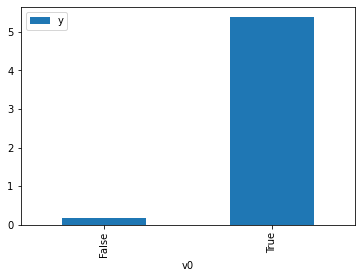

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

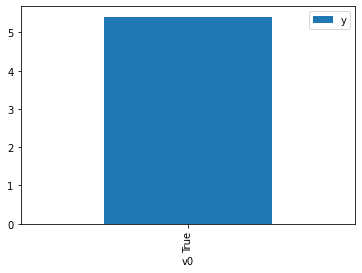

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.408141,False,-0.708645,0.609076,1.641831
1,0.502535,False,0.971443,0.340162,2.939776
2,-0.473671,False,0.296002,0.627853,1.592731
3,-0.904947,False,-0.652714,0.740159,1.351061
4,1.316463,False,0.773646,0.160963,6.212590
...,...,...,...,...,...
995,0.502972,False,-0.669703,0.340043,2.940806
996,0.886735,False,2.004691,0.244313,4.093113
997,0.110785,False,-0.061748,0.453436,2.205384
998,-0.238285,False,-1.109603,0.559009,1.788879


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.877692,True,6.739817,0.753654,1.326869
1,-0.747784,True,3.918564,0.298192,3.353543
2,-2.028673,True,2.653344,0.082297,12.151154
3,-0.788417,True,5.249544,0.287969,3.472600
4,0.127891,True,4.973631,0.551708,1.812554
...,...,...,...,...,...
995,0.435954,True,4.385570,0.641461,1.558941
996,-0.066559,True,4.313827,0.492855,2.028996
997,1.178407,True,5.414075,0.815087,1.226863
998,2.204274,True,7.907201,0.938734,1.065264


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              9933.
Date:                Wed, 03 Aug 2022   Prob (F-statistic):                        0.00
Time:                        09:26:00   Log-Likelihood:                         -1458.4
No. Observations:                1000   AIC:                                      2921.
Df Residuals:                     998   BIC:                                      2931.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2643      0.036     34.848      0.000       1.193       1.335
x2             5.0804      0.050    101.554      0.000       4.982       5.179
==============================================================================
Omnibus:                        0.873   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.646   Jarque-Bera (JB):                0.744
Skew:                          -0.021   Prob(JB):                        0.689
Kurtosis:                       3.127   Cond. No.                         1.89
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""